# Classifier

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load index csv

In [2]:
# TODO update dataset
dataset_index = pd.read_csv('./dataset/tiles-data/data.csv')
print(dataset_index.shape)
print(dataset_index.head())

dataset_size = dataset_index.shape[0]
num_classes = np.amax(dataset_index['label'])

# append path prefix
dataset_index['image-path'] = './dataset/tiles-resized/' + dataset_index['image-name']
print(dataset_index.shape)
print(dataset_index.head())

# shuffle
dataset_index = dataset_index.reindex(np.random.permutation(dataset_index.index))
print(dataset_index.shape)
print(dataset_index.head())

(629, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     38  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     26  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      9        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     36  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5.jpg     28   honors-east  ./dataset/tiles-resized/5.jpg
(629, 4)
    image-name  label    label-name                       image-path
60      61.jpg      6        dots-6   ./dataset/tiles-resized/61.jpg
247    248.jpg     27  characters-9  ./dataset/tiles-resized/248.jpg
624    624.jpg     11      bamboo-2  ./dataset/tiles-resized/624.jpg
580    581.jpg     19  characters-1  ./dataset/tiles-resized/581.jpg
406    407.jpg      4        dots-

## Load and rotate images

Instructions for updating:
Colocations handled automatically by placer.


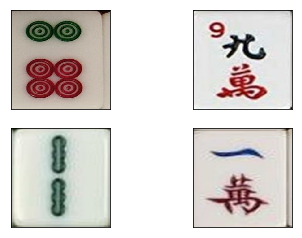

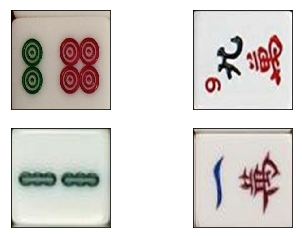

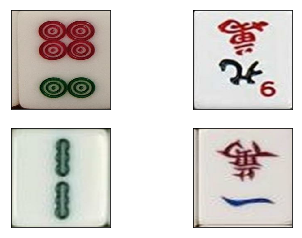

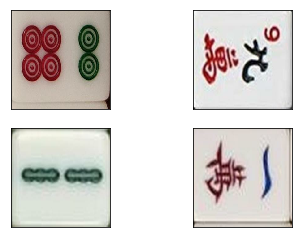

In [3]:
def show_image_sample(ds):
    for n,image in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds)

def rotate_image(image):
    image = tf.image.rot90(image)
    return image

image_ds_90 = image_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_90)

image_ds_180 = image_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_180)

image_ds_270 = image_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_270)

dataset_size *= 4

## Create image-label pairs

In [4]:
label_one_shot = tf.one_hot(dataset_index['label'], num_classes)
image_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(label_one_shot, tf.int64))

all_image_ds = image_ds.concatenate(image_ds_90).concatenate(image_ds_180).concatenate(image_ds_270)
all_image_label_ds = image_label_ds.concatenate(image_label_ds).concatenate(image_label_ds).concatenate(image_label_ds)

all_ds = tf.data.Dataset.zip((all_image_ds, all_image_label_ds))

print(all_ds.output_shapes)

(TensorShape([Dimension(320), Dimension(320), Dimension(3)]), TensorShape([Dimension(42)]))


## Split train test

In [5]:
# train-test split
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15) # test has 0.15 as well

train_ds = all_ds.take(train_size)
test_ds = all_ds.skip(train_size)
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

## Load Encoder

In [9]:
encoder = keras.models.load_model(filepath='./models/encoder.h5py')

for layer in encoder.layers:
    layer.trainable = False

## FC

In [7]:
fc = keras.Sequential(layers=[
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
], name='fc')

## Train the model

In [8]:
batch_size = 32
train_ds_batch = train_ds.batch(batch_size).repeat().prefetch(AUTOTUNE)
val_ds_batch = val_ds.batch(batch_size).repeat().prefetch(AUTOTUNE)

classifier = keras.Sequential([encoder, fc])
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# encoder.summary()
# fc.summary()
# classifier.summary()

classifier.fit(train_ds_batch.make_one_shot_iterator(),
               epochs=50,
               steps_per_epoch=int(train_size/batch_size),
               validation_data=val_ds_batch.make_one_shot_iterator(),
               validation_steps=int(val_size/batch_size),
               callbacks=[keras.callbacks.TensorBoard(log_dir='./logs')]
       )

Epoch 1/50
Instructions for updating:
Use tf.cast instead.
55/55 [==============================] - 24s 436ms/step - loss: 15.4837 - acc: 0.0227 - val_loss: 15.4770 - val_acc: 0.0256
Epoch 2/50
55/55 [==============================] - 15s 277ms/step - loss: 15.4952 - acc: 0.0237 - val_loss: 15.5100 - val_acc: 0.0232
Epoch 3/50
55/55 [==============================] - 11s 207ms/step - loss: 15.4952 - acc: 0.0237 - val_loss: 15.4642 - val_acc: 0.0290
Epoch 4/50
25/55 [============>.................] - ETA: 4s - loss: 15.4734 - acc: 0.0247

KeyboardInterrupt: 

In [ ]:
test_ds_batch = test_ds.batch(batch_size).repeat().prefetch(AUTOTUNE)

classifier.evaluate(test_ds_batch.make_one_shot_iterator(), steps=1)